# Amazon Recomendation Ranking
In this study, we will be using the amazon dataset to suggest items to purchase for users. Due to the size of the dataset, we will only use the All Beauty category to simplify our analysis.

This is NOT a binary classification problem where we have to guess if a user will buy or not buy an item. Its a **ranking** problem, where we have to suggest a list of items in a order that best suits the interests of the user. To demostrate, suppose we have user who has bought $[burger, soda]$ and suppose we have the following items to recommend $\{salad, fries, hotdog\}$, how might you reorder these recommendations so that the most likely item to be purchased comes first? A reasonable model would probably suggest $[fries, hotdog, salad]$, where fries are the most likely thing to be purchased, followed by a hotdog, and then finally salad as the least likely recommended thing to be purchased.

## Evaluation
The reason this task is significantly more difficult than classification is that there is no ground truth to evaluate against, meaning we can't use metrics like accuracy or MSE. Instead, because ranking is based on relevance (it may be better recommend salad first for user B instead of user A), its better to use relative ranking metrics like `Hit rate @ K` and `Mean Reciprocal Rank (MRR)` to evaluate our models. 

- `Hit rate @ K`: fraction of recommendations where the positive item is found within the top K positions
$$\text{Hit Rate @ K} = \frac{\text{Number of users with one hit (positive item) in top K}}{\text{total number of users}}$$

- `Mean Reciprocal Rank (MRR)`: average of the reciprocal of the rank of the positive item. Let $R$ be all sets of ordered recommened items.
$$\text{Mean Reciprocal Rank (MRR)} = \frac{1}{|R|} \sum_{r \in R}^{R} \frac{1}{\text{Rank of positive item in set } r}$$

We can get an estimate of the mean rank by computing
$$\text{mean rank} = \frac{1}{MRR}$$

Both hit rate and MRR have a range of $[0,1]$, where the higher the number, the better the results. For these metrics to work, we must generate a list of recommended items with a positive item in there. Then, we will order it using a model and evaluate it using these metrics. See the 'Data Processing' section for details.

## Validity
We believe our model will have validity in its predictions for a number of reasons:
1) Our temporal split (see Data Processing) mimics how our recommender system will work in real life: only using past data to predict future cases.
2) The lenient nature of ranking means that cases where ranks are truly 'incorrect' are rare. Just because a negative item is ranked #1, doesn't mean that its a bad recommendation. Maybe user A decided to eat the lesser picked salad instead of the commonly chosen fries.
3) Our custom models perform better than the baseline in both validation and testing evaluations.

## Data Processing

What the follow code block does:
 - Load user reviews and item metadata files 
 - Split them based on timestamps, where the first 80% go to training, the next 10% go to validation, and the last 10% go to testing
 - Assign positive samples a 1
 - Generate 99 random negative samples per positive and mark then 0
 - Save these data files as .csv on disk

### WARNING: This takes a very long time. Uncomment and only run once ever and use the saved .csv files in the data/ directory afterwards.

In [4]:
# import json
# import gzip
# import pandas as pd
# import numpy as np
# import os
# from tqdm import tqdm

# def to_df(file):
#     rows = []
#     # Handle both .gz and regular files
#     if file.endswith('.gz'):
#         open_func = gzip.open
#         mode = 'rt'
#     else:
#         open_func = open
#         mode = 'r'
    
#     with open_func(file, mode) as fp:
#         for line in fp:
#             rows.append(json.loads(line.strip()))
#     df = pd.DataFrame(rows)
#     return df

# def prep_data(review_files, meta_files, save=True):
#     # Load JSONL files
#     review_dfs = [to_df(f) for f in review_files]
#     reviews = pd.concat(review_dfs, ignore_index=True)

#     # Load and concatenate all meta files
#     item_dfs = [to_df(f) for f in meta_files]
#     items = pd.concat(item_dfs, ignore_index=True)

#     # Time-based split
#     cutoff = reviews["timestamp"].quantile(0.80)
#     train_df = reviews[reviews["timestamp"] < cutoff].copy()
#     test_df  = reviews[reviews["timestamp"] >= cutoff].copy()

#     val_cutoff = test_df["timestamp"].quantile(0.5)
#     val_df  = test_df[test_df["timestamp"] < val_cutoff].copy()
#     test_df = test_df[test_df["timestamp"] >= val_cutoff].copy()

#     # Label positives
#     train_df["label"] = 1
#     val_df["label"]   = 1
#     test_df["label"]  = 1

#     print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")
#     print(f"Items: {items.shape}")

#     # Save to CSV
#     if save:
#         os.makedirs("data", exist_ok=True)
#         train_df.to_csv("data/train.csv", index=False)
#         val_df.to_csv("data/val.csv", index=False)
#         test_df.to_csv("data/test.csv", index=False)
#         items.to_csv("data/items.csv", index=False)

#     return train_df, val_df, test_df, items

# def create_evaluation_dataset(val_df, train_df, num_negatives=99, seed=42):
#     np.random.seed(seed)
    
#     # Get all items and user purchase history from training
#     all_items = set(train_df['parent_asin'].unique())
#     user_to_items = train_df.groupby('user_id')['parent_asin'].apply(set).to_dict()
    
#     eval_rows = []
    
#     print(f"\nGenerating evaluation dataset with {num_negatives} negatives per positive...")
    
#     for idx, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Creating eval dataset"):
#         user_id = row['user_id']
#         true_item = row['parent_asin']
        
#         # Add positive example
#         eval_rows.append({
#             'user_id': user_id,
#             'item_id': true_item,
#             'label': 1
#         })
        
#         # Get items to exclude (user's training items)
#         exclude_items = user_to_items.get(user_id, set())
#         exclude_items.add(true_item)  # Also exclude the current validation item
        
#         # Sample negatives
#         available_items = list(all_items - exclude_items)
#         if len(available_items) > 0:
#             n_samples = min(num_negatives, len(available_items))
#             negatives = np.random.choice(available_items, size=n_samples, replace=False)
            
#             # Add negative examples
#             for neg_item in negatives:
#                 eval_rows.append({
#                     'user_id': user_id,
#                     'item_id': neg_item,
#                     'label': 0
#                 })
    
#     eval_df = pd.DataFrame(eval_rows)
#     print(f"Created evaluation dataset: {len(eval_df)} rows")
#     print(f"  Positives: {eval_df['label'].sum()}")
#     print(f"  Negatives: {(eval_df['label'] == 0).sum()}")
    
#     return eval_df

# if __name__ == "__main__":
#     # Default file names
#     review_file = ["All_Beauty.jsonl.gz"]
#     meta_file = ["meta_All_Beauty.jsonl.gz"]
    
#     print(f"Processing review file: {review_file}")
#     print(f"Processing meta file: {meta_file}")
    
#     # Prepare train/val/test splits
#     train_df, val_df, test_df, items = prep_data(review_file, meta_file, save=True)
    
#     # Create evaluation dataset with negatives for validation set
#     eval_val_df = create_evaluation_dataset(val_df, train_df, num_negatives=99, seed=1)
#     eval_val_df.to_csv("data/eval_val.csv", index=False)

#     eval_test_df = create_evaluation_dataset(test_df, train_df, num_negatives=99, seed=2)
#     eval_test_df.to_csv("data/eval_test.csv", index=False)
    
#     print("\nData processing complete!")
#     print(f"Output files saved to data/ directory:")
#     print("  - train.csv")
#     print("  - val.csv")
#     print("  - test.csv")
#     print("  - items.csv")
#     print("  - eval_val.csv")
#     print("  - eval_test.csv")

## EDA

In [5]:
### Imports and data loading ###
import numpy as np
import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
val = pd.read_csv('data/val.csv')
items = pd.read_csv('data/items.csv')

In [6]:
train.head(3)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,label
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True,1
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True,1
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True,1


In [7]:
items.head(3)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Howard Products,[],{'Package Dimensions': '7.1 x 5.5 x 3 inches; ...,B01CUPMQZE,NaN
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Yes To,[],"{'Item Form': 'Powder', 'Skin Type': 'Acne Pro...",B076WQZGPM,NaN
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Levine Health Products,[],{'Manufacturer': 'Levine Health Products'},B000B658RI,NaN


In [8]:
train.describe()

,rating,timestamp,helpful_vote,label
count,561222.000000,5.612220e+05,561222.000000,561222.0
mean,4.015044,1.531910e+12,1.012703,1.0
std,1.455293,7.292604e+10,5.860294,0.0
min,1.000000,9.730527e+11,0.000000,1.0
25%,3.000000,1.485613e+12,0.000000,1.0
50%,5.000000,1.548304e+12,0.000000,1.0
75%,5.000000,1.590778e+12,1.000000,1.0
max,5.000000,1.621868e+12,646.000000,1.0


Most people rated things a 4.

In [9]:
items.describe()

,average_rating,rating_number,price,bought_together
count,112590.000000,112590.000000,17704.00000,0.0
mean,3.883488,50.541345,27.25573,NaN
std,0.874384,310.992502,50.47202,NaN
min,1.000000,1.000000,0.01000,NaN
25%,3.400000,3.000000,9.99000,NaN
50%,4.000000,9.000000,16.99000,NaN
75%,4.500000,28.000000,29.90000,NaN
max,5.000000,30206.000000,2548.98000,NaN


It seems like `price` (something that should be important in recomending items) and `bought_together` are too sparse to be used as a feature.

In [10]:
print(f'Train has {train.shape[0]} reviews to {train["parent_asin"].nunique()} different items out of the possible {items["parent_asin"].nunique()} items')

Train has 561222 reviews to 90382 different items out of the possible 112590 items


In [11]:
import matplotlib.pyplot as plt

popularity_per_item = train.groupby('parent_asin')['label'].count()

plt.hist(popularity_per_item, bins=50, log=True)
plt.xlabel("Number of reviews")
plt.ylabel("Frequency (Log Scale)")
plt.title("Item Review Frequency Histogram with Logarithmic Y-axis")
plt.show()

popularity_per_item.describe()

ModuleNotFoundError: No module named 'matplotlib'

Most items have relatively few reviews, with a mean of 6 per item.

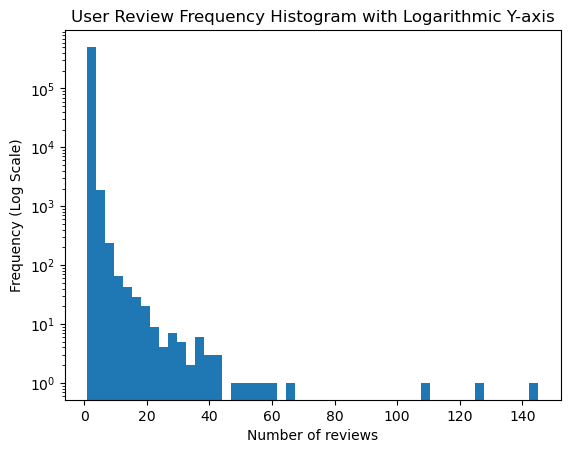

count    510379.000000
mean          1.099618
std           0.637038
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         145.000000
Name: parent_asin, dtype: float64

In [ ]:
number_of_reviews_per_user = train.groupby('user_id')['parent_asin'].count()

plt.hist(number_of_reviews_per_user, bins=50, log=True)
plt.xlabel("Number of reviews")
plt.ylabel("Frequency (Log Scale)")
plt.title("User Review Frequency Histogram with Logarithmic Y-axis")
plt.show()

number_of_reviews_per_user.describe()

Most users also don't review much, with a typical user only leaving one review. I'm not too concerned on how this affects collaborative filtering because it usually still works on sparse data.

Text(0.5, 1.0, 'Item Popularity vs Rating Scatter Plot')

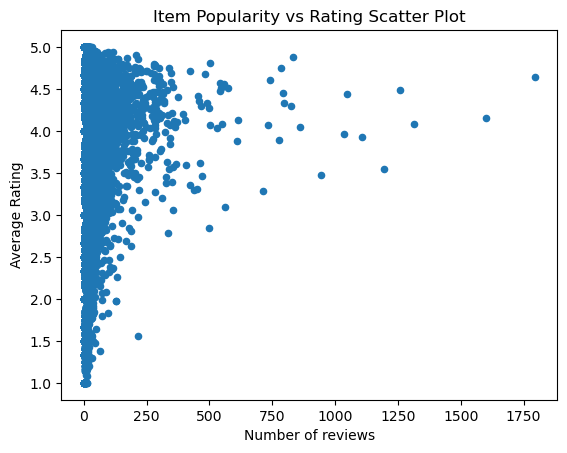

In [ ]:
train.groupby('parent_asin').agg({
            'label': 'count',
            'rating': 'mean'
        }).plot.scatter(x='label', y='rating')

plt.xlabel('Number of reviews')
plt.ylabel('Average Rating')
plt.title('Item Popularity vs Rating Scatter Plot')

Seems like items with more reviews have higher ratings

## Modeling
We will do 4 approaches for our model:
1. Popularity based approach (baseline)
2. Poularity x Item Jaccard similarity
3. User Item co-occurance
4. Bayesian personalized ranking

## Model 1: Popularity
### Baseline: Predict top K popular approaches

In [12]:
popularity = train.groupby("parent_asin")['rating'].count().sort_values(ascending=False)

for k in [5, 10, 20, 50, 100, 500, 1000]:
    topK = popularity.head(k).index.tolist()
    hit = 0
    total = len(val)

    for _, row in val.iterrows():
        if row["parent_asin"] in topK:
            hit += 1

    hit_rate = hit / total
    print(f"Hit Rate @ {k}: {hit_rate}")

# Convert full popularity ranking to list
full_rank_list = popularity.index.tolist()

# Map each item → its rank (1-based)
item_to_rank = {item: rank for rank, item in enumerate(full_rank_list, start=1)}

rr_sum = 0
count = 0

for _, row in val.iterrows():
    item = row["parent_asin"]
    if item in item_to_rank:
        rr_sum += 1 / item_to_rank[item]
    else:
        rr_sum += 0
    count += 1

MRR = rr_sum / count
print(f"MRR: {MRR}")

Hit Rate @ 5: 0.005231422747423489
Hit Rate @ 10: 0.009208444400096931
Hit Rate @ 20: 0.01485324932647214
Hit Rate @ 50: 0.022294128547603095
Hit Rate @ 100: 0.03844454264250994
Hit Rate @ 500: 0.0883925135061936
Hit Rate @ 1000: 0.12190497911707268
MRR: 0.004539223524725215


## Model 2: Popularity with Item Similarity
The score for user \(u\) and candidate item \(q\) is:

$\text{Score}(u, q) = \text{popularity}(q) \cdot \frac{1}{|I_u|} \sum_{i \in I_u} \frac{|U_q \cap U_i| + \alpha}{|U_q \cup U_i| + \beta} $

$ \text{popularity}(q) = \frac{\log\!\left(1 + \text{freq}(q)\right)} {\max_{j}\,\log\!\left(1 + \text{freq}(j)\right)}. $

Where:

- $I_u$ is the set of items purchased by user $u$
- $U_i$ is the set of users who purchased item $i$
- $\alpha, \beta$ are smoothing constants
- $\text{pop}(q)$ is the popularity of item $q$


In [13]:
import numpy as np
import pandas as pd
from tqdm import tqdm

train = pd.read_csv('data/train.csv')
eval_df = pd.read_csv('data/eval_val.csv')

print(f"Train: {len(train)} interactions")
print(f"Eval dataset: {len(eval_df)} rows")
print(f"  Positives: {eval_df['label'].sum()}")
print(f"  Negatives: {(eval_df['label'] == 0).sum()}")

Train: 561222 interactions
Eval dataset: 7015300 rows
  Positives: 70153
  Negatives: 6945147


In [14]:
# item popularity
item_counts = train['parent_asin'].value_counts()
popularity = np.log1p(item_counts) / np.log1p(item_counts).max()

# user-item and item-user mappings
user_to_items = train.groupby('user_id')['parent_asin'].apply(set).to_dict()
item_to_users = train.groupby('parent_asin')['user_id'].apply(set).to_dict()

In [15]:
# Jaccard with regularizers
def smooth_jaccard(item_i, item_j, alpha=0.01, beta=0.01):
    users_i = item_to_users.get(item_i, set())
    users_j = item_to_users.get(item_j, set())
    if not users_i or not users_j:
        return 0.0
    intersection = len(users_i & users_j)
    union = len(users_i | users_j)
    return (intersection + alpha) / (union + beta)

In [16]:
# Model: (POPULARITY × SIMILARITY)
def score_user_item(user_id, candidate_item):
    # Handle cold-start users
    if user_id not in user_to_items:
        return popularity.get(candidate_item, 0)
    
    user_items = user_to_items[user_id]
    
    # Compute average similarity to user's purchased items
    similarities = [smooth_jaccard(candidate_item, item) for item in user_items]
    mean_similarity = np.mean(similarities) if similarities else 0.0
    
    # Combine popularity and similarity
    pop_score = popularity.get(candidate_item, 0)
    final_score = pop_score * mean_similarity
    
    return final_score

In [17]:
# Use model on evaluation dataset
def score_evaluation_dataset(eval_df):
    print("\nScoring evaluation dataset with popularity × similarity model...")
    scores = []
    
    for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc="Scoring"):
        score = score_user_item(row['user_id'], row['item_id'])
        scores.append(score)
    
    eval_df = eval_df.copy()
    eval_df['score'] = scores
    return eval_df

# Score the dataset
eval_df_scored = score_evaluation_dataset(eval_df)


Scoring evaluation dataset with popularity × similarity model...


Scoring: 100%|██████████| 7015300/7015300 [02:18<00:00, 50667.91it/s]


In [ ]:
def compute_metrics(eval_df, k_values=[5, 10, 20, 50, 100]):
    """Compute Hit Rate@K and MRR from scored evaluation dataset"""
    results = {k: {'hits': 0} for k in k_values}
    reciprocal_ranks = []
    
    print("\nComputing metrics...")
    
    grouped = eval_df.groupby('user_id')
    for user_id, group in tqdm(grouped, desc="Computing metrics", total=len(grouped)):

        ranked = group.sort_values('score', ascending=False)
        ranked_labels = ranked['label'].values
        
        # Find pos items
        positive_positions = np.where(ranked_labels == 1)[0]
        
        if len(positive_positions) == 0:
            continue
        
        # Take the rank of pos
        true_rank = positive_positions[0] + 1
        
        # MRR
        reciprocal_ranks.append(1.0 / true_rank)
        
        # Hit Rate@K
        for k in k_values:
            if true_rank <= k:
                results[k]['hits'] += 1
    
    # Output
    num_users = len(eval_df.groupby('user_id'))
    
    print("\n" + "="*60)
    print("EVALUATION RESULTS: Popularity × Similarity Model")
    print("="*60)
    print(f"Total users evaluated: {num_users}")
    print()
    
    for k in k_values:
        hit_rate = results[k]['hits'] / num_users
        print(f"Hit Rate@{k:3d}: {hit_rate:.4f}")
    
    mrr = np.mean(reciprocal_ranks)
    print(f"\nMean Reciprocal Rank (MRR): {mrr:.4f}")
    print("="*60)
    
    return results, mrr

results, mrr = compute_metrics(eval_df_scored, k_values=[5, 10, 20, 50, 100])


Computing metrics...


Computing metrics: 100%|██████████| 65864/65864 [00:15<00:00, 4276.02it/s]



EVALUATION RESULTS: Popularity × Similarity Model
Total users evaluated: 65864

Hit Rate@  5: 0.2375
Hit Rate@ 10: 0.3145
Hit Rate@ 20: 0.3968
Hit Rate@ 50: 0.5312
Hit Rate@100: 0.9821

Mean Reciprocal Rank (MRR): 0.1770


### User-item co-occurance

Load data and imports:

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load data
train = pd.read_csv("data/train.csv")
val = pd.read_csv("data/val.csv")
test = pd.read_csv("data/test.csv")
items = pd.read_csv("data/items.csv")

all_reviews = pd.concat([train, val, test], ignore_index=True)

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}, Items: {len(items)}")
print(f"Total reviews: {len(all_reviews)}")

#### Model Implementation

Predicts next purchase based on similarity between candidate item and user's purchase history. 

Combines multiple similarity signals:
- Co-occurrence (items bought together)
- Category/brand matching
- Text similarity (TF-IDF on titles/descriptions)
- Review embedding similarity

In [ ]:
class CooccurrenceBaseline:
    def __init__(self):
        self.item_cooccur = defaultdict(Counter)
        self.user_items = defaultdict(set)
        self.item_category = {}
        self.item_brand = {}
        self.item_popularity = Counter()
        
        # Text similarity
        self.item_texts = {}
        self.text_vectorizer = None
        self.text_matrix = None
        self.item_to_idx = {}
        self.idx_to_item = {}
        
        # Review embeddings
        self.item_reviews = defaultdict(list)
        self.review_vectorizer = None
        self.review_matrix = None
        self.item_to_review_idx = {}
        self.review_idx_to_item = {}
        
    def fit(self, train_df, items_df, all_reviews_df):
        for _, row in train_df[train_df['label'] == 1].iterrows():
            user = row['user_id']
            item = row['parent_asin']
            self.user_items[user].add(item)
            self.item_popularity[item] += 1
        
        for _, row in all_reviews_df.iterrows():
            if 'text' in row and pd.notna(row['text']):
                self.item_reviews[row['parent_asin']].append(str(row['text']))
        
        for user, items_set in self.user_items.items():
            items_list = list(items_set)
            for i in range(len(items_list)):
                for j in range(i+1, len(items_list)):
                    item_i, item_j = items_list[i], items_list[j]
                    self.item_cooccur[item_i][item_j] += 1
                    self.item_cooccur[item_j][item_i] += 1
        
        for _, row in items_df.iterrows():
            item_id = row['parent_asin']
            
            if 'main_category' in row and pd.notna(row['main_category']):
                self.item_category[item_id] = row['main_category']
            if 'store' in row and pd.notna(row['store']):
                self.item_brand[item_id] = row['store']
            
            text = ''
            if 'title' in row and pd.notna(row['title']):
                text += str(row['title']) + ' '
            if 'description' in row and pd.notna(row['description']):
                text += str(row['description'])
            
            if text.strip():
                self.item_texts[item_id] = text.strip()
        
        self._build_text_similarity()
        self._build_review_embeddings()
    
    # TF-IDF text embeddings
    def _build_text_similarity(self):
        if not self.item_texts:
            return
        
        items = list(self.item_texts.keys())
        self.item_to_idx = {item: i for i, item in enumerate(items)}
        self.idx_to_item = {i: item for i, item in enumerate(items)}
        
        # TF-IDF
        texts = [self.item_texts[item] for item in items]
        self.text_vectorizer = TfidfVectorizer(
            max_features=1000, 
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.text_matrix = self.text_vectorizer.fit_transform(texts)
    
    def _build_review_embeddings(self):
        if not self.item_reviews:
            return
        
        items_with_reviews = [item for item, reviews in self.item_reviews.items() if reviews]
        self.item_to_review_idx = {item: i for i, item in enumerate(items_with_reviews)}
        self.review_idx_to_item = {i: item for i, item in enumerate(items_with_reviews)}
        
        review_docs = []
        for item in items_with_reviews:
            combined_reviews = ' '.join(self.item_reviews[item])
            review_docs.append(combined_reviews)
        
        # TF-IDF on reviews
        self.review_vectorizer = TfidfVectorizer(
            max_features=500,
            stop_words='english',
            max_df=0.8,
            min_df=2
        )
        self.review_matrix = self.review_vectorizer.fit_transform(review_docs)
    
    # Review embedding similarity
    def _review_similarity(self, item1, item2):
        if self.review_matrix is None:
            return 0.0
        
        idx1 = self.item_to_review_idx.get(item1)
        idx2 = self.item_to_review_idx.get(item2)
        
        if idx1 is None or idx2 is None:
            return 0.0
        
        sim = cosine_similarity(
            self.review_matrix[idx1:idx1+1],
            self.review_matrix[idx2:idx2+1]
        )[0, 0]
        
        return max(0.0, sim)
    
    def _text_similarity(self, item1, item2):
        if self.text_matrix is None:
            return 0.0
        
        idx1 = self.item_to_idx.get(item1)
        idx2 = self.item_to_idx.get(item2)
        
        if idx1 is None or idx2 is None:
            return 0.0
        
        sim = cosine_similarity(
            self.text_matrix[idx1:idx1+1], 
            self.text_matrix[idx2:idx2+1]
        )[0, 0]
        
        return max(0.0, sim)
    
    # Predict purchase score for (user, item)
    def predict_score(self, user_id, item_id):
        user_history = self.user_items.get(user_id, set())
        
        # Use item popularity if no user history
        if not user_history:
            return self.item_popularity.get(item_id, 0) / max(self.item_popularity.values())
        
        # If user has already bought item
        if item_id in user_history:
            return 0.0
        
        score = 0.0
        
        for past_item in user_history:
            item_score = 0.0
            
            # Co-occurrence score (weight: 3.0)
            cooc_count = self.item_cooccur[past_item].get(item_id, 0)
            if cooc_count > 0:
                item_score += cooc_count * 3.0
            
            # Same category (weight: 1.0)
            if (self.item_category.get(past_item) == self.item_category.get(item_id) 
                and self.item_category.get(item_id) is not None):
                item_score += 1.0
            
            # Same brand/store (weight: 1.0)
            if (self.item_brand.get(past_item) == self.item_brand.get(item_id)
                and self.item_brand.get(item_id) is not None):
                item_score += 1.0
            
            # Text similarity (weight: 2.0)
            text_sim = self._text_similarity(past_item, item_id)
            item_score += text_sim * 2.0
            
            # Review embedding similarity (weight: 2.0)
            review_sim = self._review_similarity(past_item, item_id)
            item_score += review_sim * 2.0
            
            score += item_score
        
        score = score / len(user_history)
        return score
    
    # Predict scores for test set
    def predict(self, test_df):
        scores = []
        for idx, row in test_df.iterrows():
            if idx % 10000 == 0:
                print(f"  Processed {idx}/{len(test_df)}")
            score = self.predict_score(row['user_id'], row['parent_asin'])
            scores.append(score)
        return np.array(scores)
    
    # Evaluate ranking
    def evaluate_ranking(self, test_df, items_df, k_values=[5, 10, 20], neg_samples=99):
        all_items = set(items_df['parent_asin'].values)
        
        hit_rates = {k: [] for k in k_values}
        reciprocal_ranks = []
        
        for idx, pos_row in test_df.iterrows():
            user = pos_row['user_id']
            pos_item = pos_row['parent_asin']
            
            # User's purchase history
            user_history = self.user_items.get(user, set())
            
            # Sample negative items
            available_negs = list(all_items - user_history - {pos_item})
            if len(available_negs) < neg_samples:
                sampled_negs = available_negs
            else:
                sampled_negs = np.random.choice(available_negs, neg_samples, replace=False)
            
            pos_score = self.predict_score(user, pos_item)
            neg_scores = [self.predict_score(user, neg) for neg in sampled_negs]
            
            # Rank all items
            all_scores = [pos_score] + neg_scores
            all_items_list = [pos_item] + list(sampled_negs)
            ranked_indices = np.argsort(all_scores)[::-1]
            ranked_items = [all_items_list[i] for i in ranked_indices]
            pos_rank = ranked_items.index(pos_item) + 1
            
            # Hit Rate @ K
            for k in k_values:
                hit_rates[k].append(1.0 if pos_rank <= k else 0.0)
            
            reciprocal_ranks.append(1.0 / pos_rank)
        
        results = {}
        for k in k_values:
            results[f'hit_rate@{k}'] = np.mean(hit_rates[k])
        results['mrr'] = np.mean(reciprocal_ranks)
        
        return results

#### Training

Build co-occurrence matrix and item similarity features from training data:

In [ ]:
# Train model
model = CooccurrenceBaseline()
model.fit(train, items, all_reviews)

#### Results

Ranking metrics evaluated on 1000 random samples:
- Hit Rate @ K: % of times actual item appears in top-K
- MRR: Mean reciprocal rank of actual item

In [ ]:
# Validation set
print("Validation Set:")
val_sample = val.sample(n=min(1000, len(val)), random_state=42)
val_metrics = model.evaluate_ranking(val_sample, items, k_values=[5, 10, 20], neg_samples=99)
for metric, value in val_metrics.items():
    print(f"{metric:15s}: {value:.4f}")

# Test set
print("Test Set:")
test_sample = test.sample(n=min(1000, len(test)), random_state=42)
test_metrics = model.evaluate_ranking(test_sample, items, k_values=[5, 10, 20], neg_samples=99)
for metric, value in test_metrics.items():
    print(f"{metric:15s}: {value:.4f}")

### Bayesian Personalized Ranking

#### Load Model and Evaluation Dataset

Load the trained BPR model (embeddings and mappings) and the evaluation dataset:


In [ ]:
import numpy as np
import pandas as pd
import pickle
import os
from tqdm import tqdm

# Load training data
train = pd.read_csv('data/train.csv')

# Build item popularity (like Popularity x Similarity model)
item_counts = train['parent_asin'].value_counts()
item_popularity = np.log1p(item_counts) / np.log1p(item_counts).max()
print(f"Built popularity scores for {len(item_popularity)} items")

# Build user-to-items mapping for similarity computation
user_to_items = train.groupby('user_id')['parent_asin'].apply(set).to_dict()
print(f"Built user-to-items mapping for {len(user_to_items)} users")

# Load BPR model
model_dir = "models"
user_emb_file = os.path.join(model_dir, "bpr_user_embeddings.npy")
item_emb_file = os.path.join(model_dir, "bpr_item_embeddings.npy")
mappings_file = os.path.join(model_dir, "bpr_mappings.pkl")

print("Loading BPR model...")
user_embeddings = np.load(user_emb_file)
item_embeddings = np.load(item_emb_file)
with open(mappings_file, 'rb') as f:
    loaded_mappings = pickle.load(f)
    user_to_idx = loaded_mappings['user_to_idx']
    item_to_idx = loaded_mappings['item_to_idx']
    idx_to_user = loaded_mappings['idx_to_user']
    idx_to_item = loaded_mappings['idx_to_item']

num_users = user_embeddings.shape[0]
num_items = item_embeddings.shape[0]
print(f"Loaded model: {num_users} users, {num_items} items")
print(f"Embedding dimension: {user_embeddings.shape[1]}")

# Load evaluation dataset
eval_df = pd.read_csv('data/eval_val.csv')
print(f"\nLoaded evaluation dataset: {len(eval_df)} rows")
print(f"  Positives: {eval_df['label'].sum()}")
print(f"  Negatives: {(eval_df['label'] == 0).sum()}")


Loading BPR model...
Loaded model: 510379 users, 90382 items
Embedding dimension: 50

Loaded evaluation dataset: 7015300 rows
  Positives: 70153
  Negatives: 6945147


In [ ]:
#### Score Evaluation Dataset

#Score all user-item pairs using BPR embeddings (vectorized for speed):


In [ ]:
def bpr_item_similarity(item_i, item_j):
    """Compute similarity between items using BPR embeddings (cosine similarity)"""
    if item_i not in item_to_idx or item_j not in item_to_idx:
        return 0.0
    
    emb_i = item_embeddings[item_to_idx[item_i]]
    emb_j = item_embeddings[item_to_idx[item_j]]
    
    # Cosine similarity
    norm_i = np.linalg.norm(emb_i)
    norm_j = np.linalg.norm(emb_j)
    if norm_i == 0 or norm_j == 0:
        return 0.0
    
    return np.dot(emb_i, emb_j) / (norm_i * norm_j)

def score_user_item_bpr(user_id, candidate_item):
    """
    Pure BPR scoring using item embeddings for similarity:
    Score = popularity × bpr_item_similarity
    """
    # Get popularity score
    pop_score = item_popularity.get(candidate_item, 0)
    
    # Cold-start user: use popularity only
    if user_id not in user_to_items:
        return pop_score
    
    user_items = user_to_items[user_id]
    
    # PURE BPR: Use only BPR item embedding similarity
    bpr_sims = [bpr_item_similarity(candidate_item, item) for item in user_items]
    mean_bpr_sim = np.mean(bpr_sims) if bpr_sims else 0.0
    # Normalize to [0, 1] (cosine sim is [-1, 1])
    mean_bpr_sim = (mean_bpr_sim + 1) / 2
    
    # Final score: popularity × BPR similarity
    return pop_score * mean_bpr_sim

def score_evaluation_dataset(eval_df):
    """Score all user-item pairs in the evaluation dataset"""
    print("\nScoring evaluation dataset with BPR item similarity...")
    scores = []
    
    for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc="Scoring"):
        score = score_user_item_bpr(row['user_id'], row['item_id'])
        scores.append(score)
    
    eval_df = eval_df.copy()
    eval_df['score'] = scores
    
    # Add tiny random tiebreaker to break score ties
    np.random.seed(42)
    eval_df['score_tiebreaker'] = np.random.rand(len(eval_df)) * 1e-10
    eval_df['score_final'] = eval_df['score'] + eval_df['score_tiebreaker']
    
    return eval_df

# Score the dataset
eval_df_scored = score_evaluation_dataset(eval_df)



Scoring evaluation dataset with BPR model...


In [ ]:
#### Compute Evaluation Metrics

#Compute Hit Rate@K and MRR metrics:


In [ ]:
def compute_metrics(eval_df, k_values=[5, 10, 20, 50, 100, 200]):
    """Compute Hit Rate@K and MRR from scored evaluation dataset"""
    results = {k: {'hits': 0} for k in k_values}
    reciprocal_ranks = []
    
    print("\nComputing metrics...")
    
    grouped = eval_df.groupby('user_id')
    for user_id, group in tqdm(grouped, desc="Computing metrics", total=len(grouped)):
        ranked = group.sort_values('score_final', ascending=False)
        ranked_labels = ranked['label'].values
        
        positive_positions = np.where(ranked_labels == 1)[0]
        
        if len(positive_positions) == 0:
            continue
        
        true_rank = positive_positions[0] + 1
        reciprocal_ranks.append(1.0 / true_rank)
        
        for k in k_values:
            if true_rank <= k:
                results[k]['hits'] += 1
    
    num_users = len(eval_df.groupby('user_id'))
    
    print("\n" + "="*60)
    print("EVALUATION RESULTS")
    print("="*60)
    print(f"Total users evaluated: {num_users}")
    print()
    
    for k in k_values:
        hit_rate = results[k]['hits'] / num_users
        print(f"Hit Rate@{k:3d}: {hit_rate:.4f}")
    
    mrr = np.mean(reciprocal_ranks)
    print(f"\nMean Reciprocal Rank (MRR): {mrr:.4f}")
    print("="*60)
    
    return results, mrr

results, mrr = compute_metrics(eval_df_scored, k_values=[5, 10, 20, 50, 100, 200])



Computing metrics...


Computing metrics: 100%|██████████| 65864/65864 [00:08<00:00, 7919.07it/s] 



EVALUATION RESULTS
Total users evaluated: 65864

Hit Rate@  5: 0.0519
Hit Rate@ 10: 0.1000
Hit Rate@ 20: 0.1962
Hit Rate@ 50: 0.4977
Hit Rate@100: 0.9883
Hit Rate@200: 0.9990

Mean Reciprocal Rank (MRR): 0.0528
